In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATADIR = '/content/drive/MyDrive/CI7000/CI7000_Project_Dissertation/datasets'

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/CI7000/CI7000_Project_Dissertation/datasets/models/facenet_keras.h5 /content/

In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=20, resize=0.4)

In [ ]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 3023
n_features: 1850
n_classes: 62


In [ ]:
target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

In [ ]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [ ]:
from keras.models import load_model, Model
from tqdm import tqdm
import cv2
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, normalized_mutual_info_score

model = load_model("/content/facenet_keras.h5")

batch_size = 128

def run_algorithm(X):
    """
    Runs the HyperParameter Tuning for Effective Clustering
    """

    idx = 0
    homogeneity_train_dict = {}
    homogeneity_dict = {}
    completeness_train_dict = {}
    completeness_dict = {}
    v_measure_train_dict = {}
    v_measure_dict = {}
    ari_train_dict = {}
    ari_dict = {}
    ami_train_dict = {}
    ami_dict = {}

    for eps in tqdm(range(1, 12, 3)):
      for min_samples in range(1, 20, 5):
        db = DBSCAN(eps=eps, min_samples=min_samples)
        images = []
        for x in X:
          images.append(cv2.resize(x.reshape(50,37), (160,160)))
        images = np.stack(images)
        images = np.concatenate([np.expand_dims(images, 3)]*3, axis=2)
        images = l2_normalize(prewhiten(images.reshape(-1,160,160,3)))
        emb = []
        for ii in tqdm(range(0, len(images), batch_size)):
          emb.append(model.predict(images[ii:ii+batch_size]))
        emb = np.vstack(emb)
        db.fit(euclidean_distances(emb))
        labels = db.labels_

        homogeneity_dict[(eps, min_samples)] = homogeneity_score(y, labels)
        completeness_dict[(eps, min_samples)] = completeness_score(y, labels)
        v_measure_dict[(eps, min_samples)] = v_measure_score(y, labels)
        ari_dict[(eps, min_samples)] = adjusted_rand_score(y, labels)
        ami_dict[(eps, min_samples)] = normalized_mutual_info_score(y, labels)

    return homogeneity_dict, completeness_dict, v_measure_dict, ari_dict, ami_dict

In [ ]:
homogeneity_dict, completeness_dict, v_measure_dict, ari_dict, ami_dict = run_algorithm(X)

100%|██████████| 24/24 [01:27<00:00,  3.64s/it]

100%|██████████| 24/24 [01:26<00:00,  3.60s/it]

100%|██████████| 24/24 [01:27<00:00,  3.64s/it]

100%|██████████| 24/24 [01:28<00:00,  3.69s/it]

100%|██████████| 24/24 [01:30<00:00,  3.78s/it]

100%|██████████| 24/24 [01:26<00:00,  3.60s/it]

100%|██████████| 24/24 [01:28<00:00,  3.67s/it]

100%|██████████| 24/24 [01:28<00:00,  3.67s/it]

100%|██████████| 24/24 [01:32<00:00,  3.87s/it]

100%|██████████| 24/24 [01:25<00:00,  3.55s/it]

100%|██████████| 24/24 [01:25<00:00,  3.58s/it]

100%|██████████| 24/24 [01:25<00:00,  3.58s/it]

100%|██████████| 4/4 [25:01<00:00, 375.29s/it]


In [ ]:
homogeneity_dict, completeness_dict, v_measure_dict, ari_dict, ami_dict

({(1, 1): 1.0000000000000004,
  (1, 6): 0.0,
  (1, 11): 0.0,
  (1, 16): 0.0,
  (4, 1): 1.0000000000000004,
  (4, 6): 0.0,
  (4, 11): 0.0,
  (4, 16): 0.0,
  (7, 1): 0.9988748598428571,
  (7, 6): 0.0,
  (7, 11): 0.0,
  (7, 16): 0.0,
  (10, 1): 0.8342417205099455,
  (10, 6): 0.02460199624630689,
  (10, 11): 0.0051192350050653064,
  (10, 16): 0.0027457131505907837},
 {(1, 1): 0.4577238950103615,
  (1, 6): 1.0,
  (1, 11): 1.0,
  (1, 16): 1.0,
  (4, 1): 0.4577238950103615,
  (4, 6): 1.0,
  (4, 11): 1.0,
  (4, 16): 1.0,
  (7, 1): 0.4575230594659242,
  (7, 6): 1.0,
  (7, 11): 1.0,
  (7, 16): 1.0,
  (10, 1): 0.43152111206043686,
  (10, 6): 0.2353637518944223,
  (10, 11): 0.21455754682897846,
  (10, 16): 0.24302104258294577},
 {(1, 1): 0.6279980681898722,
  (1, 6): 0.0,
  (1, 11): 0.0,
  (1, 16): 0.0,
  (4, 1): 0.6279980681898722,
  (4, 6): 0.0,
  (4, 11): 0.0,
  (4, 16): 0.0,
  (7, 1): 0.6275871117912613,
  (7, 6): 0.0,
  (7, 11): 0.0,
  (7, 16): 0.0,
  (10, 1): 0.5688157460440307,
  (10, 6): 0

In [ ]:
images2 = []
files = []
for ij, str_samp in tqdm(enumerate(metadata_CACD.iterrows())):
    _, str_samp = str_samp
    filename2 = str_samp['filename']
    img2 = os.path.join(DATADIR, 'CACD2000', 'CACD2000', filename2)
    if os.path.isfile(img2):
      image2 = cv2.resize(imageio.imread(img2), (160,160))
      files.append(filename2)
      if len(image2.shape) == 2:
        image2 = np.concatenate([np.expand_dims(image2, 2)]*3, axis=2)
      images2.append(image2)
    if ij == 5000:
      break

5000it [00:08, 574.24it/s]


In [ ]:
images2 = np.stack(images2)

In [ ]:
from keras.models import load_model, Model
from tqdm import tqdm
import cv2
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, normalized_mutual_info_score

model = load_model("/content/facenet_keras.h5")

batch_size = 128

def run_algorithm(X):
    """
    Runs the HyperParameter Tuning for Effective Clustering
    """

    idx = 0

    eps = 12
    min_samples = 1
    
    db = DBSCAN(eps=eps, min_samples=min_samples)
    images3 = l2_normalize(prewhiten(images2.reshape(-1,160,160,3)))
    emb = []
    for ii in tqdm(range(0, len(images2), batch_size)):
      emb.append(model.predict(images2[ii:ii+batch_size]))
    emb = np.vstack(emb)
    db.fit(euclidean_distances(emb))
    labels = db.labels_

    ages = [f.split("_")[0] for f in files]

    cluster_labels = pd.DataFrame()
    cluster_labels['ages'] = ages
    cluster_labels['labels'] = labels
    cluster_labels['eps'] = eps
    cluster_labels['min_samples'] = min_samples

    return cluster_labels

In [ ]:
cluster_labels = run_algorithm(None)

100%|██████████| 12/12 [00:46<00:00,  3.91s/it]


In [ ]:
cluster_labels

,ages,labels,eps,min_samples
0,53,0,12,1
1,54,1,12,1
2,54,2,12,1
3,54,3,12,1
4,54,4,12,1
...,...,...,...,...
1453,56,1444,12,1
1454,56,1445,12,1
1455,56,1446,12,1
1456,58,1447,12,1


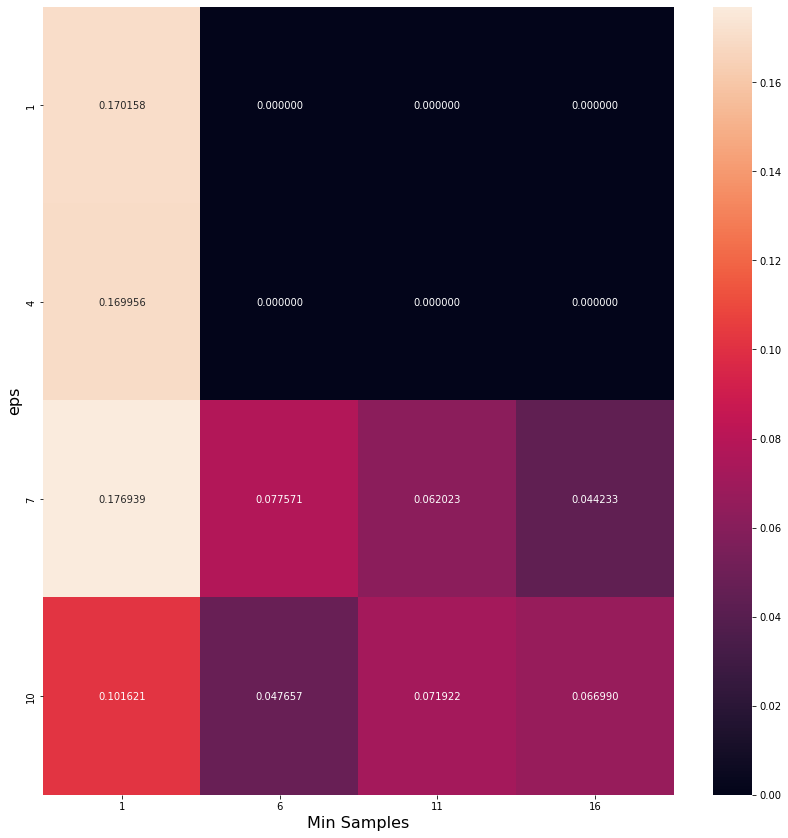

In [ ]:
import seaborn as sns

# Heatmap visualization of LogitBoost Algorithm
fig, ax = plt.subplots(1,1,figsize=(12,12))
sns.heatmap(data=np.array([v for (eps, ms), v in list(ami_dict.items())]).reshape(-1,4), ax=ax, annot=True, fmt="f")
ax.set_yticklabels([1,4,7,10])
ax.set_xticklabels([1,6,11,16])
ax.set_xlabel("Min Samples", fontsize=16)
ax.set_ylabel("eps", fontsize=16)
plt.tight_layout(pad=2.0)
plt.show()

In [ ]:
rse = pd.read_csv("rolling-standard-error.csv", index_col=0)

In [ ]:
rse.mean(axis=1).loc[[30, 50, 70, 90]]

30    0.040837
50    0.024328
70    0.027452
90    0.044983
dtype: float64

In [ ]:
rse.sem(axis=1).loc[[30, 50, 70, 90]]

30    0.000440
50    0.000221
70    0.000166
90    0.000226
dtype: float64

In [ ]:
rse

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
26,0.051029,0.053888,0.053325,0.059159,0.048453,0.056913,0.054832,0.054548,0.051083,0.055172,...,0.055798,0.053377,0.063540,0.050211,0.053775,0.051838,0.061100,0.055928,0.056250,0.058788
27,0.049484,0.051067,0.048631,0.053547,0.044185,0.051621,0.050882,0.050128,0.047508,0.050964,...,0.051677,0.048675,0.057698,0.047355,0.049118,0.047674,0.055056,0.053690,0.051932,0.052932
28,0.047445,0.046539,0.044499,0.050800,0.040554,0.048887,0.047936,0.045935,0.043007,0.047650,...,0.047405,0.044483,0.052301,0.043799,0.045392,0.046035,0.050239,0.048863,0.047109,0.047961
29,0.044325,0.043696,0.040900,0.048408,0.039351,0.045430,0.044256,0.042624,0.039600,0.044755,...,0.043986,0.041935,0.047899,0.040373,0.042680,0.042406,0.046932,0.044980,0.043119,0.044591
30,0.040553,0.040388,0.037719,0.044115,0.037284,0.043599,0.042604,0.039272,0.036836,0.041127,...,0.041120,0.038661,0.045104,0.037625,0.041347,0.042118,0.043302,0.042043,0.042032,0.041820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0.067918,0.071039,0.068699,0.067312,0.070183,0.067318,0.067059,0.070106,0.071764,0.067530,...,0.074064,0.067925,0.068000,0.068106,0.067972,0.067499,0.067298,0.068368,0.068204,0.069939
98,0.073873,0.077199,0.074746,0.073133,0.074370,0.073263,0.073001,0.073489,0.076527,0.073440,...,0.078243,0.073599,0.074347,0.074545,0.073597,0.073105,0.072721,0.072214,0.074048,0.076435
99,0.080378,0.083381,0.081225,0.079524,0.079611,0.078736,0.079005,0.079746,0.082812,0.079190,...,0.084795,0.079421,0.080504,0.079554,0.079515,0.079303,0.078712,0.078238,0.079384,0.082504
100,0.087698,0.091685,0.091169,0.088331,0.089321,0.088148,0.088719,0.089842,0.091863,0.088589,...,0.091750,0.089135,0.090063,0.089166,0.089564,0.088063,0.087608,0.088028,0.088716,0.092815


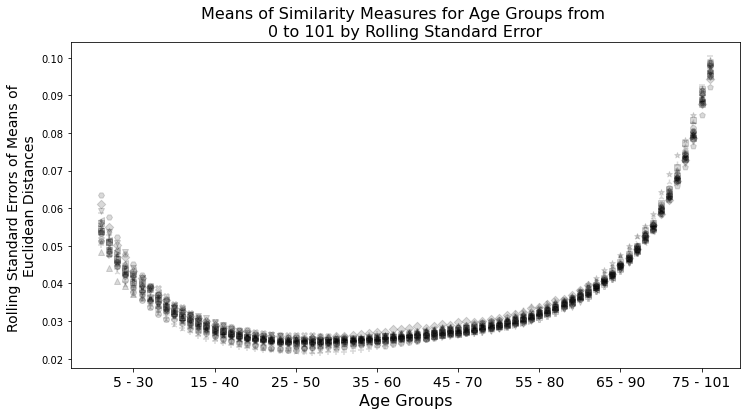

In [ ]:
markers = {
    0: "."	,
    1: ","	,
    2: "o"	,
    3: "v"	,
    4: "^"	,
    5: "<"	,
    6: ">"	,
    7: "1"	,
    8: "2"	,
    9: "3"	,
    10: "4"	,
    11: "8"	,
    12: "s"	,
    13: "p"	,
    14: "P"	,
    15: "*"	,
    16: "h"	,
    17: "H"	,
    18: "+"	,
    19: "x"	,
    20: "X",	
    21: "D"	,
    22: "d"	,
    23: "|"	,
    24: "_"
}
fig, ax = plt.subplots(1,1,figsize=(12,6))
for idx, col in rse.iteritems():
  ax.scatter(col.index, col.values, marker=markers[int(idx)], c='k', alpha=0.15)
ax.set_title("Means of Similarity Measures for Age Groups from \n0 to 101 by Rolling Standard Error", fontsize=16)
ax.set_xlabel("Age Groups", fontsize=16)
ax.set_ylabel("Rolling Standard Errors of Means of \nEuclidean Distances", fontsize=14)
ax.set_xticks([30,40,50,60,70,80,90,100])
ax.set_xticklabels(['5 - 30', '15 - 40', '25 - 50', '35 - 60', '45 - 70', '55 - 80', '65 - 90', '75 - 101'], fontsize=14)
fig.show()

In [ ]:
rsd = pd.read_csv("rolling-standard-deviation.csv", index_col=0)

In [ ]:
rsd.sem(axis=1).loc[[30, 50, 70, 90]]

30    0.025739
50    0.020159
70    0.012957
90    0.011583
dtype: float64

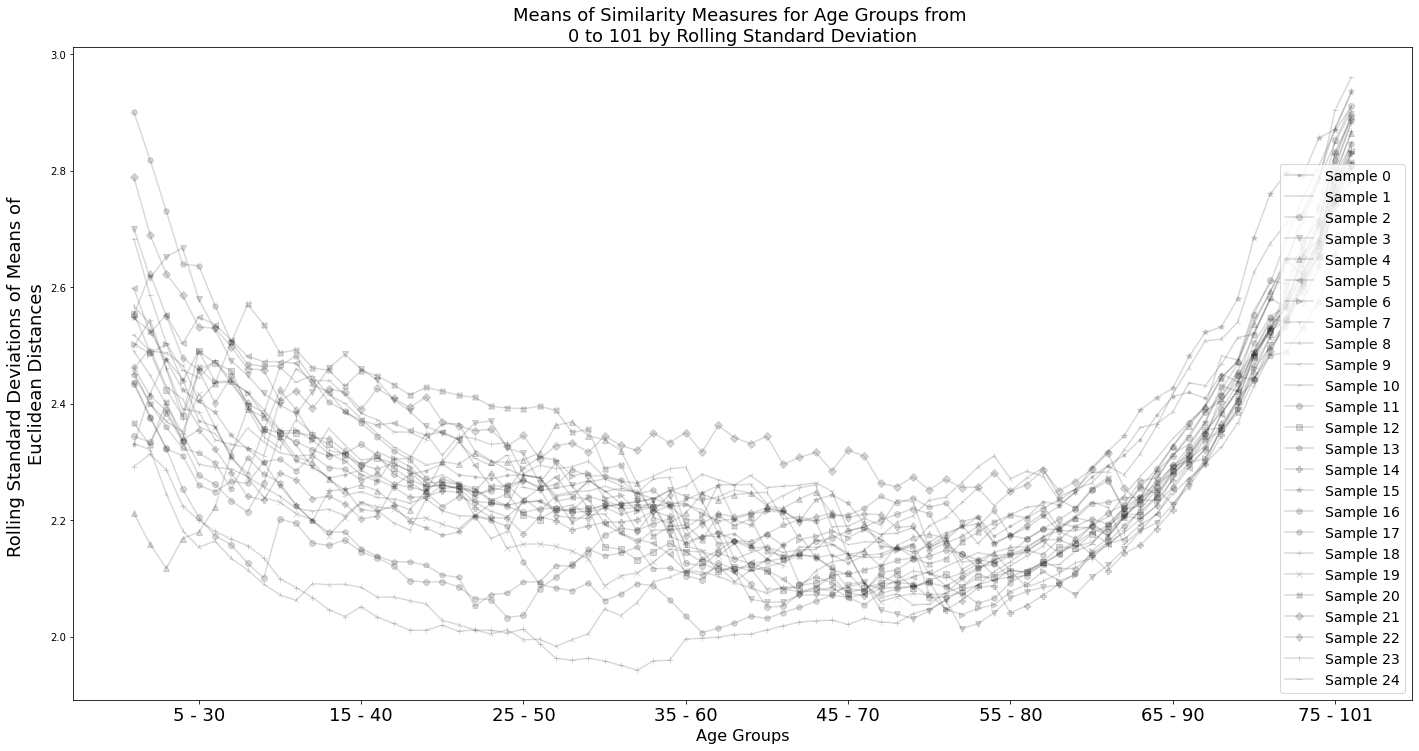

In [ ]:
markers = {
    0: "."	,
    1: ","	,
    2: "o"	,
    3: "v"	,
    4: "^"	,
    5: "<"	,
    6: ">"	,
    7: "1"	,
    8: "2"	,
    9: "3"	,
    10: "4"	,
    11: "8"	,
    12: "s"	,
    13: "p"	,
    14: "P"	,
    15: "*"	,
    16: "h"	,
    17: "H"	,
    18: "+"	,
    19: "x"	,
    20: "X",	
    21: "D"	,
    22: "d"	,
    23: "|"	,
    24: "_"
}
fig, ax = plt.subplots(1,1,figsize=(24,12))
for idx, col in rsd.iteritems():
  ax.plot(col.index, col.values, marker=markers[int(idx)], c='k', alpha=0.15, label='Sample ' + str(idx))
ax.set_title("Means of Similarity Measures for Age Groups from \n0 to 101 by Rolling Standard Deviation", fontsize=18)
ax.set_xlabel("Age Groups", fontsize=16)
ax.set_ylabel("Rolling Standard Deviations of Means of \nEuclidean Distances", fontsize=18)
ax.set_xticks([30,40,50,60,70,80,90,100])
ax.legend(fontsize=14)
ax.set_xticklabels(['5 - 30', '15 - 40', '25 - 50', '35 - 60', '45 - 70', '55 - 80', '65 - 90', '75 - 101'], fontsize=18)
fig.show()

In [ ]:
rsd

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
26,2.329514,2.460020,2.434327,2.700648,2.211942,2.598134,2.503124,2.490163,2.332002,2.518665,...,2.547226,2.436698,2.900668,2.292191,2.454887,2.366471,2.789262,2.553182,2.567862,2.683707
27,2.417628,2.494969,2.375984,2.616158,2.158721,2.522052,2.485959,2.449078,2.321082,2.489946,...,2.524767,2.378104,2.818945,2.313599,2.399756,2.329226,2.689854,2.623138,2.537258,2.586090
28,2.477164,2.429856,2.323347,2.652304,2.117369,2.552440,2.502791,2.398340,2.245423,2.487864,...,2.475043,2.322529,2.730706,2.286778,2.369974,2.403544,2.623040,2.551166,2.459601,2.504088
29,2.442697,2.408019,2.253945,2.667714,2.168617,2.503588,2.438890,2.348968,2.182291,2.466389,...,2.424046,2.311002,2.639647,2.224893,2.352068,2.336948,2.586371,2.478795,2.376245,2.457373
30,2.370899,2.361207,2.205210,2.579108,2.179739,2.548946,2.490765,2.295981,2.153563,2.404433,...,2.404020,2.260252,2.636941,2.199724,2.417313,2.462362,2.531571,2.457986,2.457368,2.444971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2.564746,2.682614,2.594228,2.541859,2.650279,2.542082,2.532296,2.647365,2.709973,2.550082,...,2.796824,2.564994,2.567830,2.571855,2.566776,2.548931,2.541344,2.581753,2.575551,2.641053
98,2.634692,2.753307,2.665823,2.608306,2.652415,2.612921,2.603605,2.620979,2.729359,2.619231,...,2.790528,2.624899,2.651576,2.658663,2.624854,2.607298,2.593586,2.575533,2.640929,2.726074
99,2.707928,2.809096,2.736455,2.679148,2.682071,2.652587,2.661673,2.686616,2.789914,2.667907,...,2.856719,2.675660,2.712162,2.680139,2.678834,2.671704,2.651782,2.635814,2.674415,2.779546
100,2.743995,2.868737,2.852596,2.763783,2.794764,2.758067,2.775931,2.811050,2.874297,2.771873,...,2.870752,2.788937,2.817989,2.789921,2.802368,2.755416,2.741167,2.754302,2.775848,2.904088


In [ ]:
rsd.index.values

array([ 26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101])

In [ ]:
med = pd.read_csv("rolling-euclidean-distances.csv", index_col=0)

In [ ]:
med.mean(axis=1).loc[[30, 50, 70, 90]]

30    0.496518
50    0.540291
70    0.576184
90    0.579703
dtype: float64

In [ ]:
med.sem(axis=1).loc[[30, 50, 70, 90]]

30    0.003755
50    0.003223
70    0.002638
90    0.002472
dtype: float64

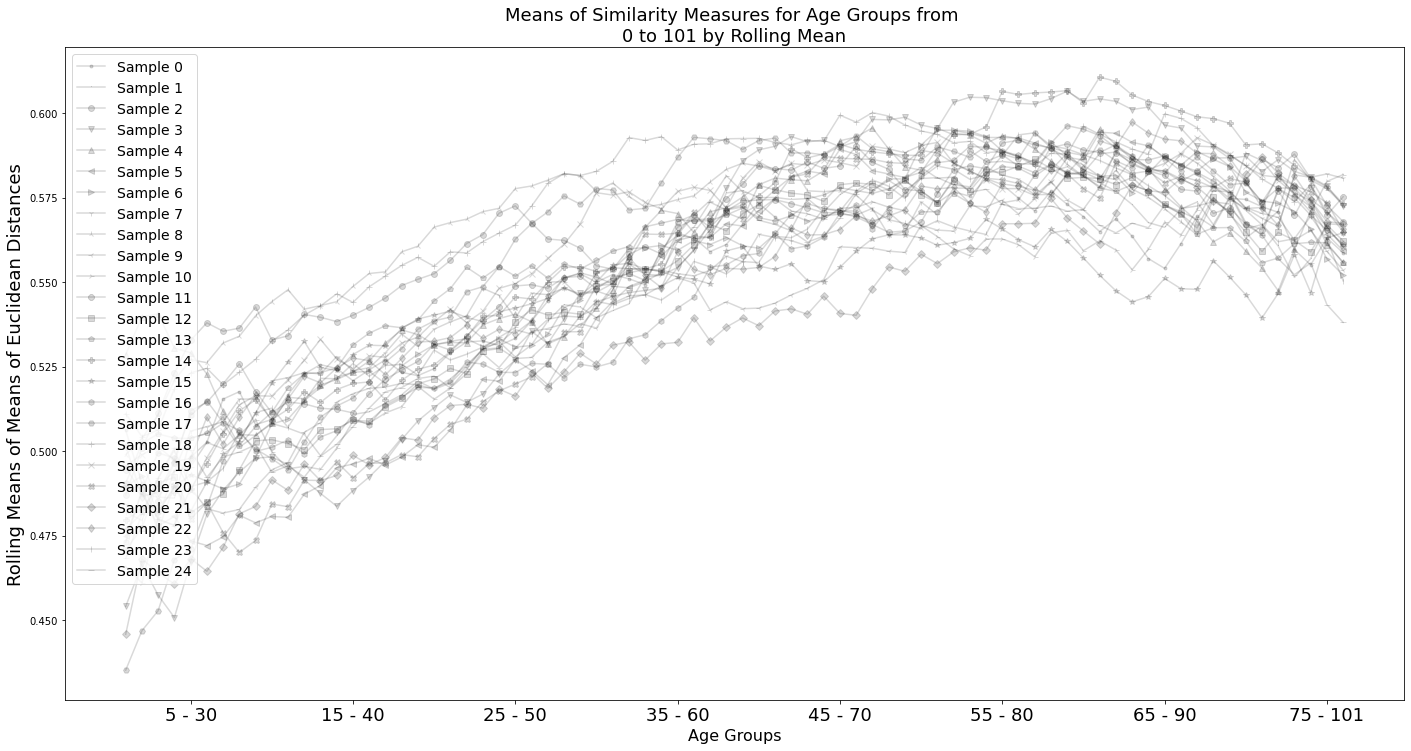

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(24,12))
for idx, col in med.iteritems():
  ax.plot(col.index, col.values, marker=markers[int(idx)], c='k', alpha=0.15, label='Sample ' + str(idx))
ax.set_title("Means of Similarity Measures for Age Groups from \n0 to 101 by Rolling Mean", fontsize=18)
ax.set_xlabel("Age Groups", fontsize=16)
ax.set_ylabel("Rolling Means of Means of Euclidean Distances", fontsize=18)
ax.legend(fontsize=14)
ax.set_xticks([30,40,50,60,70,80,90,100])
ax.set_xticklabels(['5 - 30', '15 - 40', '25 - 50', '35 - 60', '45 - 70', '55 - 80', '65 - 90', '75 - 101'], fontsize=18)
fig.show()

In [ ]:
db = DBSCAN(eps=0.1, min_samples=1)
db.fit(rsd)

DBSCAN(eps=0.1, min_samples=1)

In [ ]:
rsd.shape

(76, 25)

In [ ]:
db.labels_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 12, 13, 13, 14,
       14, 15, 16, 16, 17, 17, 17, 18, 19, 20, 20, 20, 21, 21, 22, 23, 24,
       25, 26, 27, 28, 28, 29, 29, 30, 30, 31, 32, 32, 33, 33, 33, 34, 34,
       35, 35, 36, 37, 37, 37, 38, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52, 53, 54, 55])

In [ ]:
db = DBSCAN(eps=0.02, min_samples=1)
db.fit(med)

DBSCAN(eps=0.02, min_samples=1)

In [ ]:
med.shape

(76, 25)

In [ ]:
db.labels_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 12, 13, 13, 13,
       13, 13, 13, 13, 13, 14, 14, 15, 16, 17, 18, 18, 19, 19, 20, 20, 21,
       22, 23, 24, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28,
       29, 29, 29, 30, 30, 30, 31, 31, 31, 32, 33, 34, 34, 35, 35, 35, 36,
       36, 37, 38, 39, 40, 41, 42, 43])

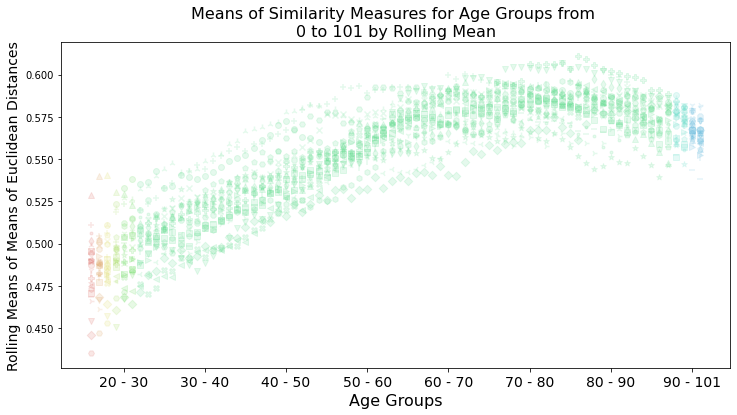

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
colors = sns.color_palette("hls", 13)
for idx, col in med.iteritems():
  for i in range(13):
    ax.scatter(col.index[db.labels_==i], col.values[db.labels_==i], marker=markers[int(idx)], c=colors[i], alpha=0.15)
ax.set_title("Means of Similarity Measures for Age Groups from \n0 to 101 by Rolling Mean", fontsize=16)
ax.set_xlabel("Age Groups", fontsize=16)
ax.set_ylabel("Rolling Means of Means of Euclidean Distances", fontsize=14)
ax.set_xticks([30,40,50,60,70,80,90,100])
ax.set_xticklabels(['20 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 101'], fontsize=14)
fig.show()

https://towardsdatascience.com/preserving-geodesic-distance-for-non-linear-datasets-isomap-d24a1a1908b2

500it [00:01, 486.46it/s]


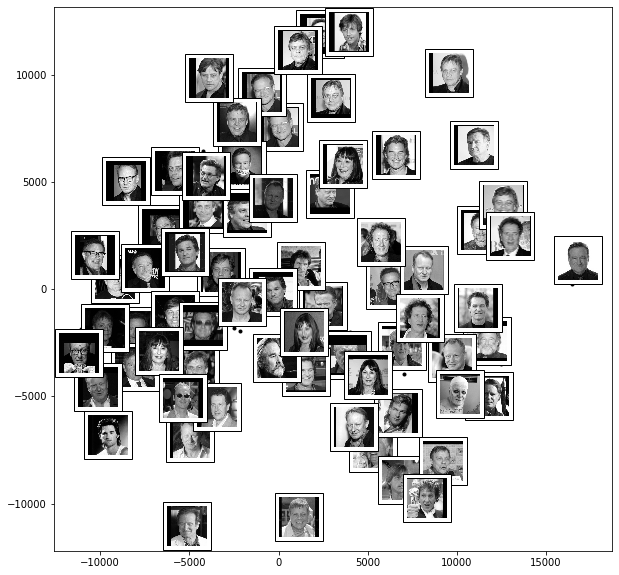

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.manifold import Isomap
from matplotlib.offsetbox import AnnotationBbox
from matplotlib import offsetbox
from sklearn.datasets import fetch_openml
from sklearn.datasets import fetch_lfw_people
import os
import scipy.io
import imageio
# faces = fetch_lfw_people(min_faces_per_person=40)

mat = scipy.io.loadmat(os.path.join(DATADIR, "celebrity2000_meta.mat"))
age, identity, year, feature_1, feature_2, feature_3, feature_4, name = mat['celebrityImageData'][0][0]
metadata_CACD = pd.DataFrame(np.vstack([age.flatten(), identity.flatten(), year.flatten(), 
                            np.array(list(map(lambda x: x.tolist()[0][0].split("_")[1] + "_" + x.tolist()[0][0].split("_")[2], name))), 
                            np.array(list(map(lambda x: x.tolist()[0][0], name)))]).T, 
                  columns=['age', 'identity', 'year', 'name', 'filename'])
metadata_CACD['age'] = metadata_CACD['age'].astype(int)
metadata_CACD['identity'] = metadata_CACD['identity'].astype(int)
metadata_CACD['year'] = metadata_CACD['year'].astype(int)

images2 = []
for ij, str_samp in tqdm(enumerate(metadata_CACD.iterrows())):
    _, str_samp = str_samp
    filename2 = str_samp['filename']
    img2 = os.path.join(DATADIR, 'CACD2000', 'CACD2000', filename2)
    if os.path.isfile(img2):
      image2 = cv2.resize(imageio.imread(img2), (80,80))
      if len(image2.shape) == 3:
          image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)
      images2.append(image2)
    if ij == 500:
      break

images2 = np.vstack(images2)

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

from sklearn.manifold import Isomap
# model = Isomap(n_components=2)
# proj = model.fit_transform()
# proj.shape

fig, ax = plt.subplots(figsize=(10, 10))
plot_components(images2.reshape(-1,80,80).reshape(-1,80*80),
                model=Isomap(n_components=2),
                images=images2.reshape(-1,80,80)[:, ::2, ::2])

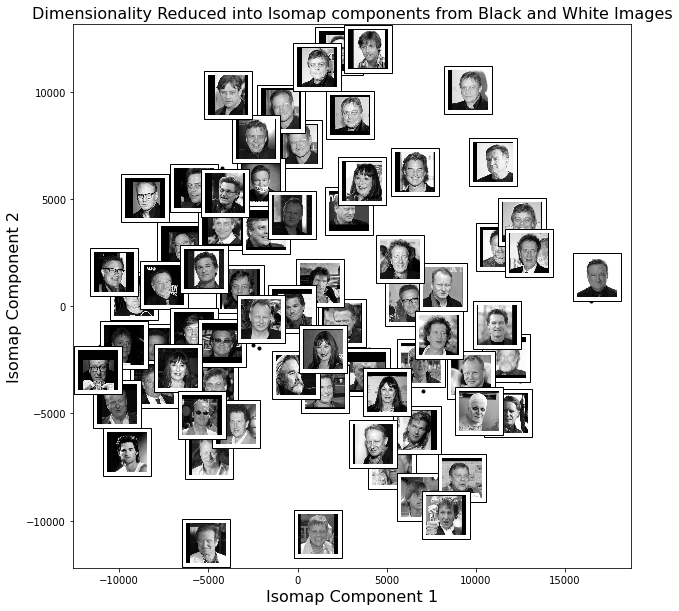

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(images2.reshape(-1,80,80).reshape(-1,80*80),
                model=Isomap(n_components=2),
                images=images2.reshape(-1,80,80)[:, ::2, ::2])
plt.xlabel("Isomap Component 1", fontsize=16)
plt.ylabel("Isomap Component 2", fontsize=16)
plt.title("Dimensionality Reduced into Isomap components from Black and White Images", fontsize=16)
plt.show()

In [ ]:
med = pd.read_csv("rolling-euc-dist-fgnet-agedb.csv", index_col=0)

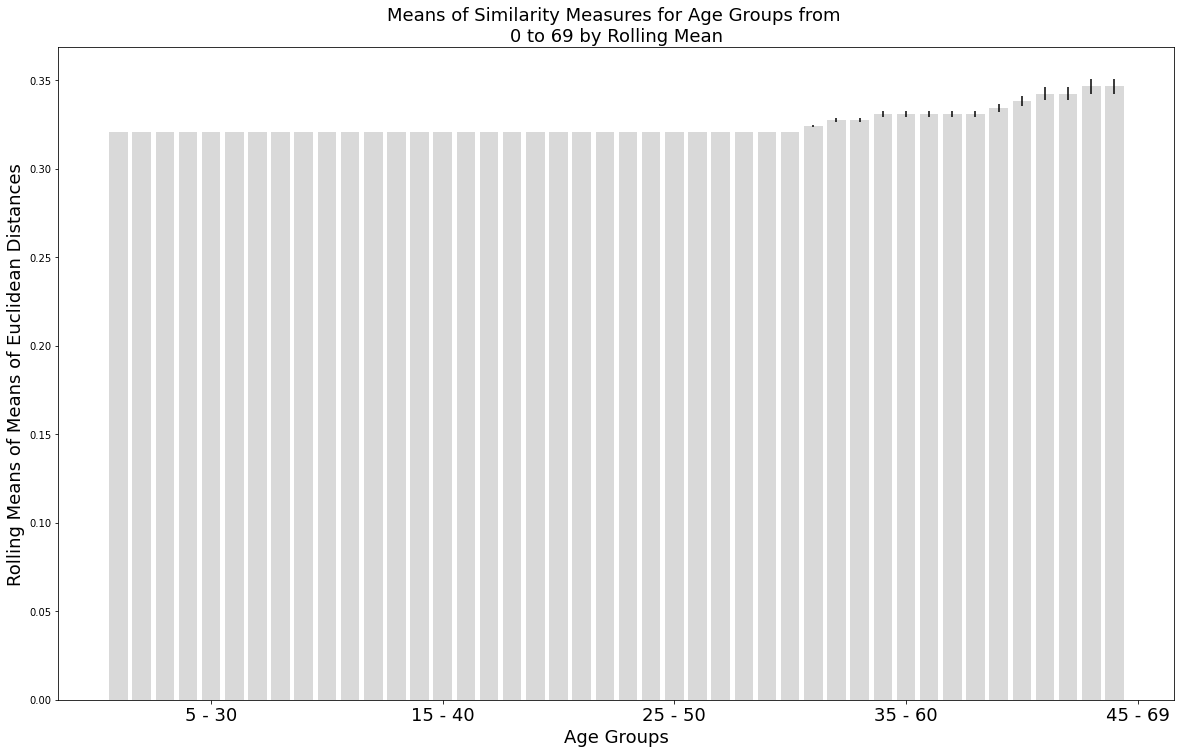

In [ ]:
markers = {
    0: "."	,
    1: ","	,
    2: "o"	,
    3: "v"	,
    4: "^"	,
    5: "<"	,
    6: ">"	,
    7: "1"	,
    8: "2"	,
    9: "3"	,
    10: "4"	,
    11: "8"	,
    12: "s"	,
    13: "p"	,
    14: "P"	,
    15: "*"	,
    16: "h"	,
    17: "H"	,
    18: "+"	,
    19: "x"	,
    20: "X",	
    21: "D"	,
    22: "d"	,
    23: "|"	,
    24: "_"
}
fig, ax = plt.subplots(1,1,figsize=(20,12))

ax.bar(med.index.values, med.mean(axis=1), color='k', alpha=0.15, yerr=1.96*med.sem(axis=1))

ax.set_title("Means of Similarity Measures for Age Groups from \n0 to 69 by Rolling Mean", fontsize=18)
ax.set_xlabel("Age Groups", fontsize=18)
ax.set_ylabel("Rolling Means of Means of Euclidean Distances", fontsize=18)
ax.set_xticks([30,40,50,60,70])
ax.set_xticklabels(['5 - 30', '15 - 40', '25 - 50', '35 - 60', '45 - 69'], fontsize=18)
fig.show()